In [4]:
# IMPORTANT! : Follow this link to see the two maps : 
 # https://nbviewer.org/github/BaptisteLazarus/Python/blob/main/AnalysisVisualization_SelfServiceBikesInParis.ipynb

#Analyzing and maping of "Vélib'" in Paris (self service bikes system) by connecting to the datas in real time and by using folium library.

In [5]:
import pandas

In [6]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

In [7]:
import requests

In [8]:
import folium

In [9]:
#import of stations informations and store its in a pandas dataframe
url = "https://opendata.paris.fr/api/records/1.0/search/"
dataset = "velib-disponibilite-en-temps-reel"
#get the number of stations
r = requests.get(url = url, params = dict(dataset = dataset)).json()
#get everuthing
df = pandas.DataFrame([s["fields"] for s in requests.get(url = url, params = dict(dataset = dataset, rows = r['nhits'])).json()['records']])
df.head()

,name,stationcode,ebike,mechanical,coordonnees_geo,duedate,numbikesavailable,numdocksavailable,capacity,is_renting,is_installed,nom_arrondissement_communes,is_returning
0,Benjamin Godard - Victor Hugo,16107,10,5,"[48.865983, 2.275725]",2023-01-17T09:43:34+00:00,15,19,35,OUI,OUI,Paris,OUI
1,Mairie de Rosny-sous-Bois,31104,6,8,"[48.871256519012, 2.4865807592869]",2023-01-17T09:43:33+00:00,14,15,30,OUI,OUI,Rosny-sous-Bois,OUI
2,Jourdan - Stade Charléty,14014,1,3,"[48.819428333369, 2.3433353751898]",2023-01-17T09:42:31+00:00,4,55,60,OUI,OUI,Paris,OUI
3,Basilique,32017,1,4,"[48.93626891059109, 2.3588666820200914]",2023-01-17T09:43:37+00:00,5,13,22,OUI,OUI,Saint-Denis,OUI
4,Messine - Place Du Pérou,8026,6,3,"[48.875448033960744, 2.315508019010038]",2023-01-17T09:41:56+00:00,9,0,12,OUI,OUI,Paris,OUI


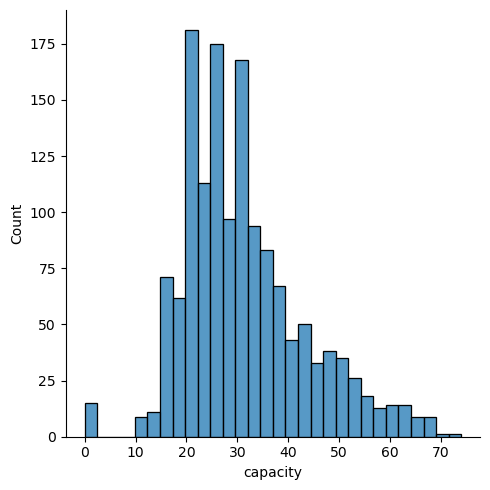

In [10]:
#capacity distribution
seaborn.displot(data = df, x = "capacity")

<AxesSubplot:xlabel='capacity'>

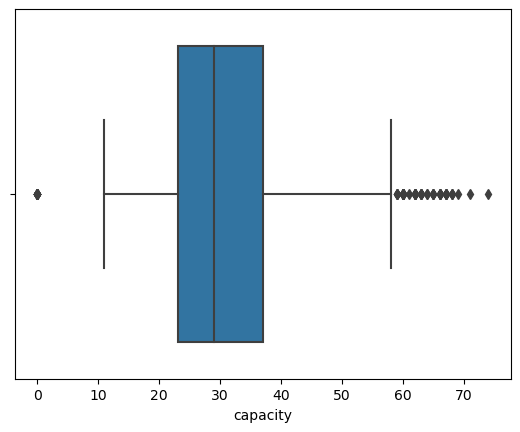

In [11]:
#capacity distribution displayed with boxplot
seaborn.boxplot(data = df, x = "capacity")

<AxesSubplot:xlabel='capacity', ylabel='nom_arrondissement_communes'>

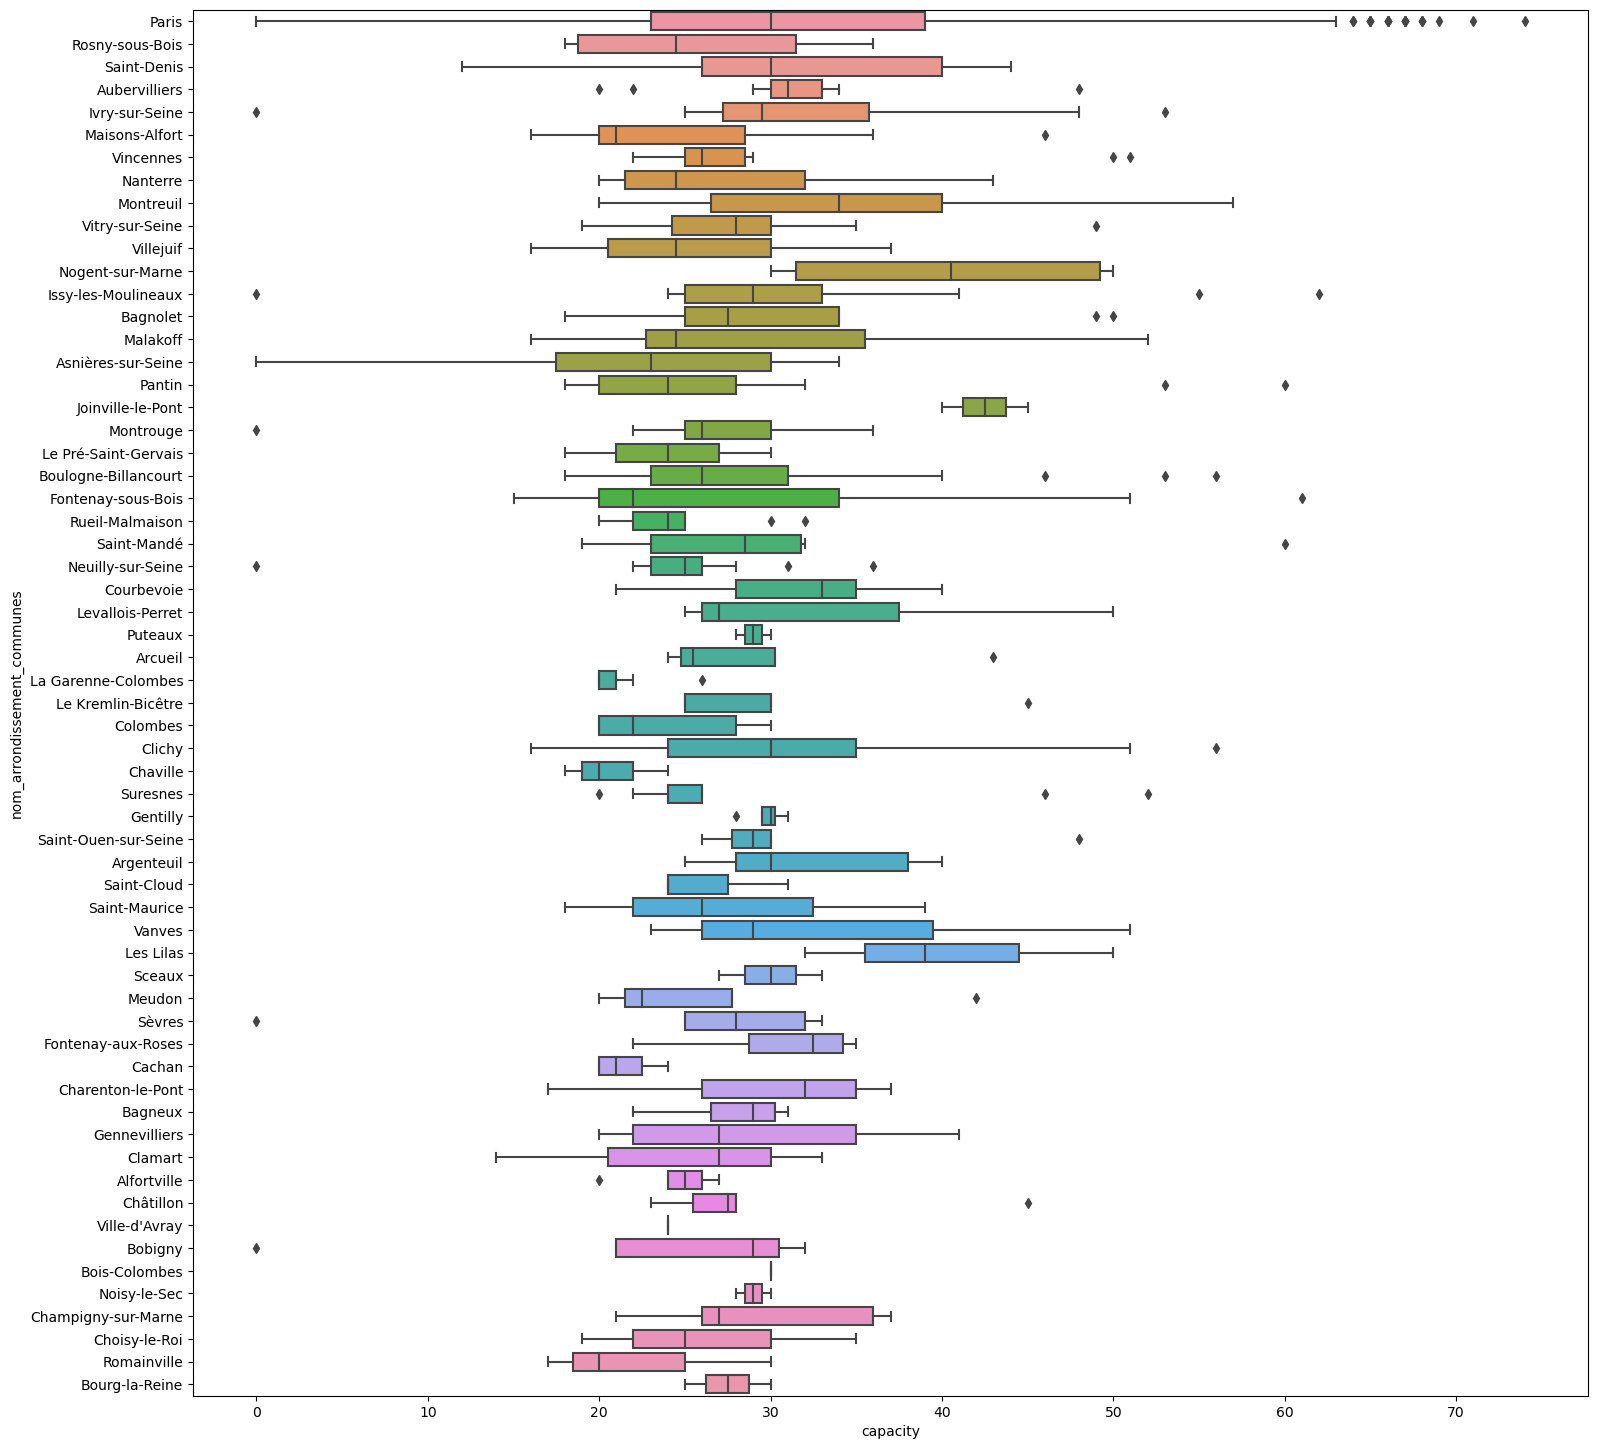

In [12]:
#cities distribution
plt.figure(figsize=(18,18))
seaborn.boxplot(data = df, x = "capacity", y = "nom_arrondissement_communes")

In [13]:
#Display the stations on a map
def popup(station):
    msg = "<strong>" + station["name"] + "</strong>"\
        + " (" + station["nom_arrondissement_communes"] + ")"
    return msg

centre = [48.87, 2.35]
paris = folium.Map(location = centre, zoom_start = 11)

for st in range(df.shape[0]):
    station = df.iloc[st,:]
    # print(popup(station))
    folium.Marker(station["coordonnees_geo"],
                  tooltip = station["name"],
                  popup = popup(station)).add_to(paris)
    
paris

In [14]:
#stations number for each city
ag_count = df.filter(["nom_arrondissement_communes", "capacity"])\
    .groupby("nom_arrondissement_communes")\
    .count()\
    .rename(columns = {"capacity": "NumStations"})
ag_count.head()

,NumStations
nom_arrondissement_communes,
Alfortville,5
Arcueil,4
Argenteuil,5
Asnières-sur-Seine,12
Aubervilliers,13


In [15]:
#capacity number for each city
ag_sum = df.filter(["nom_arrondissement_communes", "capacity", "numbikesavailable", "numdocksavailable"])\
    .groupby("nom_arrondissement_communes")\
    .aggregate(["sum"])\
    .droplevel(level = 1, axis = 1)
ag_sum.head()

,capacity,numbikesavailable,numdocksavailable
nom_arrondissement_communes,,,
Alfortville,122,79,42
Arcueil,118,17,98
Argenteuil,161,90,69
Asnières-sur-Seine,254,64,180
Aubervilliers,404,199,184


In [16]:
#average GPS coordinates (display preparation)
ag_mean = df.filter(["nom_arrondissement_communes"])\
    .assign(lat = [c[0] for c in df["coordonnees_geo"]])\
    .assign(lng = [c[1] for c in df["coordonnees_geo"]])\
    .groupby("nom_arrondissement_communes")\
    .aggregate(["mean"])\
    .droplevel(level = 1, axis = 1)
ag_mean.head()

,lat,lng
nom_arrondissement_communes,,
Alfortville,48.801567,2.422036
Arcueil,48.806420,2.331766
Argenteuil,48.947850,2.239504
Asnières-sur-Seine,48.915342,2.288465
Aubervilliers,48.910740,2.381001


In [17]:
#resume
ag_final = pandas.concat([ag_count, ag_sum, ag_mean], axis = 1)
ag_final.head()

,NumStations,capacity,numbikesavailable,numdocksavailable,lat,lng
nom_arrondissement_communes,,,,,,
Alfortville,5,122,79,42,48.801567,2.422036
Arcueil,4,118,17,98,48.806420,2.331766
Argenteuil,5,161,90,69,48.947850,2.239504
Asnières-sur-Seine,12,254,64,180,48.915342,2.288465
Aubervilliers,13,404,199,184,48.910740,2.381001


In [18]:
#display markers for each city(located in stations center of the city) with belows informations
def popup_city(city):
    msg = "<strong>" + city.name + "</strong><ul>"\
        + "<li>Number of stations : " + str(city["NumStations"]) + "</li>"\
        + "<li>Total Capacity : " + str(city["capacity"]) + "</li>"\
        + "<li>Bikes Available : " + str(city["numbikesavailable"]) + "</li>"\
        + "<li>Docks Available : " + str(city["numdocksavailable"]) + "</li></ul>"
    iframe = folium.IFrame(msg)
    popup = folium.Popup(iframe,
                     min_width = 300,
                     max_width = 300)
    return popup

center = [48.87, 2.35]
map_city = folium.Map(location = center, zoom_start = 11)

for v in range(ag_final.shape[0]): #
    city = ag_final.iloc[v,:]
    folium.Marker([city.lat, city.lng],
                  tooltip = city.name,
                  popup = popup_city(city)).add_to(map_city)
map_city